# Trip_planner

### Flow Chart

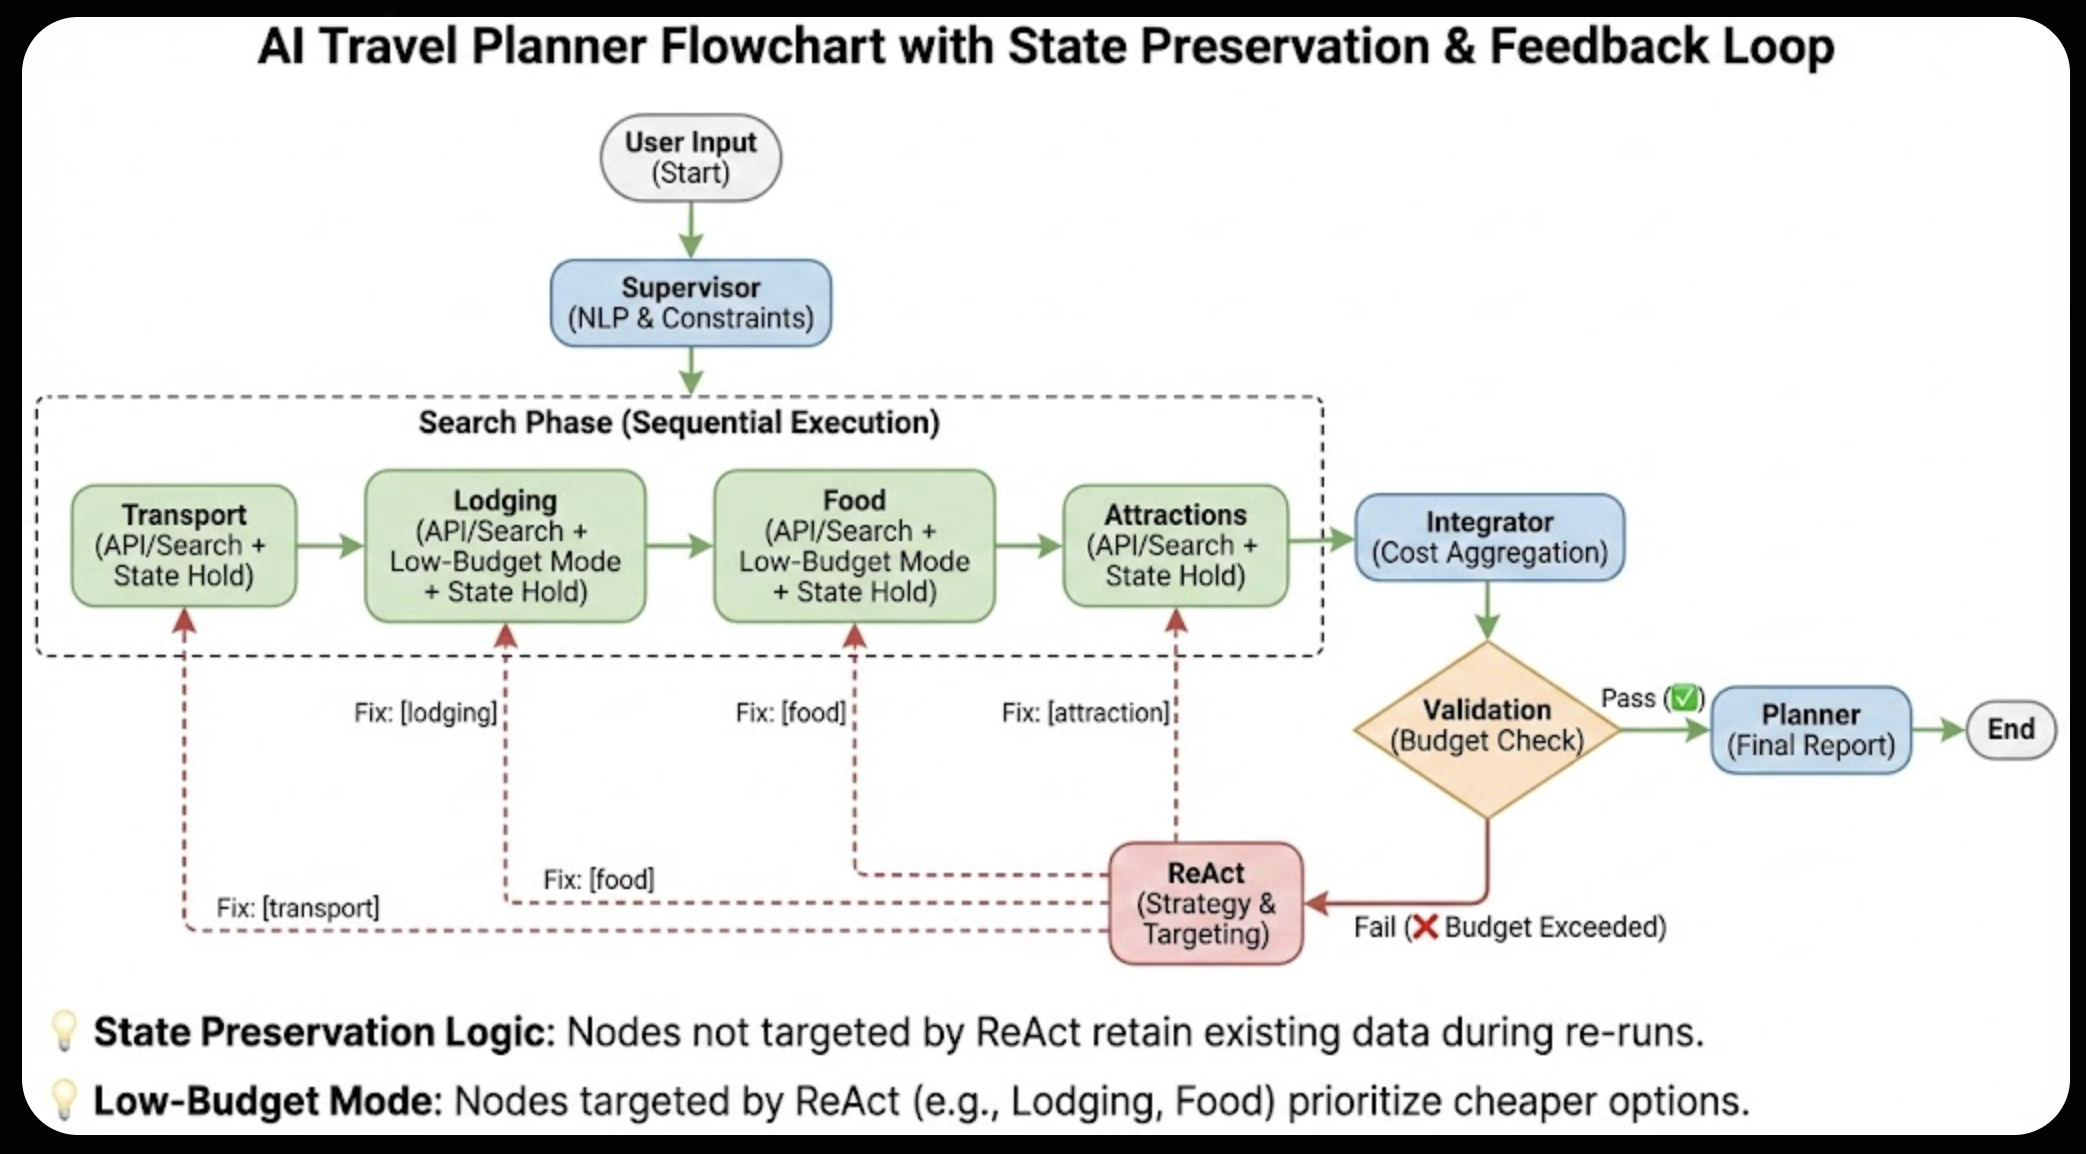

### 추후 계획

1. 각 일차의 계획을 시간 순으로 세우기 (거리 순)
2. 리액트 노드에서 supervisor 노드로도 이동하는 edge추가
3. API + tavily의 가격 한계 극복 방법
4. ReAct노드의 사고 판단 수정(자꾸 같은 노드로 가는 문제 발생)

### 구현 내용

1. transport node
   - 자차 유무를 먼저 파악. 자차 이용 시 kakao api를 이용해서 유류비 계산
   - 자차가 없으면 기차 -> 버스 -> 자가용 순으로 국토교통부(TAGO) API를 조회해서 기차표, 버스표 가져옴(가격은 없음)
   - 가져온 표를 tavily 라이브러리를 이용하여 가격을 크롤링


2. lodging node
    - kakao API를 이용하여 {destination} 호텔 5개 검색
    - tavily 이용하여 각 호텔의 가격 크롤링 후 가장 저렴한 숙소 선택
    - ReAct 노드에서 숙소 가격 줄이라고 명령 시 호텔 -> 모텔로 변경하여 같은 작업 수행


3. food node
    - kakao API를 이용하여 {destination} 음식점 검색(1박 : 4곳, 2박 : 7곳, 3박 : 10곳)
    - tavily 이용하여 각 음식점의 가격 크롤링 후 가장 저렴한 음식점들 선택
    - ReAct 노드에서 음식점 가격 줄이라고 명령 시 음식점 -> 국밥, 분식 등으로 변경하여 같은 작업 수행


4. attraction node
    - kakao API를 이용하여 {destination} 관광지 검색(1박 : 3곳, 2박 : 4곳, 3박 : 5곳)
    - tavily 이용하여 각 관광지의 가격 크롤링
    - ReAct 노드에서 관광지 가격 줄이라고 명령 시 1박 : 2곳, 2박 : 3곳, 3박 : 4곳으로 관광지 줄여서 다시 검색

## 임포트 & 전역변수

In [1]:
from langchain_ollama import ChatOllama


llm = ChatOllama(
    model="llama3",  
    temperature=0    # 0으로 설정해야 답변이 일관성 있게 나옵니다.
)

print(f"✅ Ollama LLM 설정 완료: {llm.model}")

✅ Ollama LLM 설정 완료: llama3


In [2]:
from typing import TypedDict, Dict, Any, List
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph
import json, re
import requests
import math
from datetime import datetime, timedelta
import random
from tavily import TavilyClient
DATA_GO_KR_KEY = "c4407b5c5f60c9b952bc1f472d9c3231e98d8d6844b2a9cd9b9324887c9fcb86"
KAKAO_API_KEY = "6ebf3f3fd63b0a4d455916cb4f631ea4"
TAVILY_API_KEY = "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"

STATION_DB = {
    "기차": {
        "서울": "NAT010000", 
        "용산": "NAT010032",
        "부산": "NAT011573",   # 부산역
        "울산": "NAT014445",   # 🚄 KTX 울산(통도사)역 (주로 KTX 이용 시)
        "태화강": "NAT011599", # 🚆 태화강역 (주로 무궁화호 이용 시)
        "동대구": "NAT011668", 
        "대전": "NAT010032", 
        "광주": "NAT010522",   
        "강릉": "NAT010065", 
        "목포": "NAT010486"
    },
    "버스": {
        "서울": "NAEK010", 
        "부산": "NAEK700", 
        "울산": "NAEK715", 
        "대구": "NAEK801", 
        "대전": "NAEK300", 
        "광주": "NAEK500"  
    }
}

AREA_CODE_DB = {
    "서울": "1", "인천": "2", "대전": "3", "대구": "4", "광주": "5", 
    "부산": "6", "울산": "7", "세종": "8", "경기": "31", "강원": "32", 
    "충북": "33", "충남": "34", "경북": "35", "경남": "36", 
    "전북": "37", "전남": "38", "제주": "39"
}

CITY_CODES = {
    "서울": "11", "용산": "11",
    "부산": "21", "대구": "22", "인천": "23", "광주": "24", 
    "대전": "25", "울산": "26", "경기": "31", "강원": "32", 
    "충북": "33", "충남": "34", "전북": "35", "전남": "36", 
    "경북": "37", "경남": "38"
}

PRICE_TABLE = {
    "호텔": 150000,
    "리조트": 200000,
    "펜션": 120000,
    "풀빌라": 300000,
    "모텔": 60000,
    "게스트하우스": 40000,
    "호스텔": 35000,
    "캠핑": 50000
}

PRICE_TABLE = {
    "분식": 8000, "김밥": 7000, "국수": 9000, "카페": 6000, 
    "치킨": 22000, "피자": 25000, "중식": 12000, "일식": 15000,
    "양식": 20000, "한식": 15000, "고기": 35000, "술집": 20000, "뷔페": 50000
}

def fetch_price_via_tavily(query: str, min_price=3000, max_price=1000000) -> int:
    """
    Tavily로 웹 검색 후 가격 정보(숫자) 추출
    """
    try:
        # API 키 확인 (전역 변수 TAVILY_API_KEY 사용)
        tavily = TavilyClient(api_key=TAVILY_API_KEY) 
        
        # 검색 (상위 2개 결과 참조)
        response = tavily.search(query=query, search_depth="basic", max_results=2)
        context = "\n".join([r['content'] for r in response.get('results', [])])
        
        # 텍스트에서 '00,000원' 또는 '00000원' 패턴 찾기
        prices = re.findall(r'([0-9]{1,3}(?:,[0-9]{3})*)원', context)
        valid_prices = []
        for p in prices:
            val = int(p.replace(',', ''))
            # 유효 범위 필터링
            if min_price <= val <= max_price:
                valid_prices.append(val)
        
        if valid_prices:
            # 평균값 리턴 (100원 단위 절삭)
            return (sum(valid_prices) // len(valid_prices) // 100) * 100
            
    except Exception as e:
        pass
    
    return 0  # 검색 실패 시 0 리턴

# ==========================================
# 🛠️ 공통 도구: Kakao 장소 검색
# ==========================================
def fetch_kakao_places(keyword: str, category_code: str = "", size: int = 5) -> List[Dict]:
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {"query": keyword, "size": size}
    
    # 카테고리 코드가 있으면 필터링 적용 (예: AD5=숙소, FD6=음식점)
    if category_code:
        params["category_group_code"] = category_code

    try:
        res = requests.get(url, headers=headers, params=params, timeout=5)
        if res.status_code == 200:
            return res.json().get('documents', [])
    except:
        pass
    return []

## Status 정의

In [3]:

class TravelState(TypedDict):
    # 🌟 사용자 입력 (자연어)
    user_query: str  
    
    # ⚙️ 파싱된 제약조건
    constraints: Dict[str, Any]
    
    # 📦 각 단계별 수집 데이터
    transport: Dict[str, Any]
    lodging: Dict[str, Any]
    food: Dict[str, Any]
    attractions: Dict[str, Any]
    
    # 📊 통합 및 검증 데이터
    integrated: Dict[str, Any]
    validation: Dict[str, Any]
    
    # 🤖 ReAct 관련
    react_decision: str
    revision_request: str
    retry_count: int
    
    # 📝 최종 결과
    final_plan: str

## 노드 정의

### supervisor node

In [4]:
def extract_json(text: str) -> Dict[str, Any]:
    try:
        # 마크다운 제거
        match = re.search(r"```json\s*(.*?)```", text, re.DOTALL)
        if match: text = match.group(1)
        else:
            match = re.search(r"```\s*(.*?)```", text, re.DOTALL)
            if match: text = match.group(1)
        
        # 중괄호 찾기
        start_idx = text.find('{')
        end_idx = text.rfind('}')
        if start_idx != -1 and end_idx != -1:
            text = text[start_idx : end_idx + 1]

        # 🌟 [핵심] JSON 내 주석(// ...) 제거 (파싱 에러 방지)
        text = re.sub(r"//.*", "", text)
        
        return json.loads(text)
    except Exception as e:
        # 에러 발생 시 원본 텍스트를 일부 출력해 디버깅 도움
        print(f"   🚨 JSON 파싱 에러: {e}")
        return {}

# ==========================================
# 🧠 2. Supervisor Node (예산 보정 로직 강화)
# ==========================================
def supervisor_node(state: Dict[str, Any]) -> Dict[str, Any]:
    print("\n🧠 [Supervisor] 사용자 자연어 요청 분석 중...")
    
    query = state.get("user_query", "")
    
    # 🔍 [디버깅] 입력된 문장 확인
    # print(f"   (입력 확인: {query})")

    prompt = f"""
    당신은 여행 플래너의 Supervisor입니다.
    사용자의 자연어 요청을 분석하여, 여행 계획에 필요한 제약조건을 JSON으로 추출하세요.

    [사용자 요청]
    "{query}"

    [추출 규칙]
    1. 출발지(origin): "OO에서 출발" 등의 표현을 찾아 반드시 적으세요.
    2. 도착지(destination): 필수입니다.
    3. 예산(budget_total): 숫자만 적으세요. (단위 계산 정확히)
    4. 인원(people): 명수를 숫자로 적으세요.
    5. 기간: nights(박), days(일)로 구분하세요.

    [🚫 금지] 주석(//), 설명글 절대 금지. 오직 JSON만 출력.

    [출력 예시]
    {{
      "origin": "서울",
      "destination": "부산",
      "duration_nights": 1,
      "duration_days": 2,
      "budget_total": 200000,
      "people": 2,
      "theme": ["맛집"]
    }}
    """
    
    response = llm.invoke(prompt)
    constraints = extract_json(response.content)

    # 파싱 실패 시 기본값
    if not constraints:
        print("   ⚠️ 파싱 실패. 기본값(서울, 1명)으로 진행합니다.")
        constraints = {"destination": "서울", "people": 1}

    # 🌟 [강력한 예산 보정 로직]
    # AI가 '2000000'으로 잘못 뽑아도, 텍스트에 '20만원'이 있으면 200,000으로 강제 수정
    man_match = re.search(r'(\d+)\s*만', query)
    if man_match:
        raw_num = int(man_match.group(1))
        corrected_budget = raw_num * 10000
        
        # AI 값과 다르면 보정 로그 출력
        if constraints.get("budget_total") != corrected_budget:
            print(f"   💰 [예산 보정] 텍스트 '{man_match.group(0)}' 감지 -> {corrected_budget:,}원으로 강제 설정")
            constraints["budget_total"] = corrected_budget
            
    elif not constraints.get("budget_total"):
        constraints["budget_total"] = 300000 # 기본값

    # 데이터 보정 (출발지, 인원, 기간)
    if not constraints.get("origin"): constraints["origin"] = "서울"
    if not constraints.get("people"): constraints["people"] = 1
    
    nights = constraints.get("duration_nights", 1)
    days = constraints.get("duration_days", 2)
    constraints["duration"] = f"{nights}박{days}일" 
    
    print(f"\n📋 [Supervisor] 확정된 제약조건 (JSON):")
    print(json.dumps(constraints, ensure_ascii=False, indent=2))
    print("-" * 40)
    
    return {"constraints": constraints}

### 교통 노드

In [5]:
def format_time_str(time_str: str) -> str:
    """시간 포맷 변환: YYYYMMDDHHMM -> HH:MM"""
    try:
        s = str(time_str)
        if len(s) >= 12: return f"{s[8:10]}:{s[10:12]}"
        return s
    except: return str(time_str)

def get_coords(query: str) -> tuple:
    """카카오 로컬 API로 좌표 조회"""
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    try:
        res = requests.get(url, headers=headers, params={"query": query})
        docs = res.json().get('documents')
        if docs: return float(docs[0]['y']), float(docs[0]['x'])
    except: pass
    return None

def calculate_fuel_cost(origin: str, dest: str) -> Dict[str, Any]:
    """자차 이용 시 예상 주유비 계산"""
    p1 = get_coords(origin)
    p2 = get_coords(dest)
    
    # 좌표를 못 구하면 기본값 반환
    if not p1 or not p2:
        return {
            "type": "자차", "vehicle": "자가용", 
            "start_station": origin, "end_station": dest, 
            "departure_time": "자유", "arrival_time": "-", 
            "cost": 50000, "note": "좌표 조회 실패"
        }

    # Haversine 거리 계산
    R = 6371
    dLat = math.radians(p2[0]-p1[0]); dLon = math.radians(p2[1]-p1[1])
    a = math.sin(dLat/2)**2 + math.cos(math.radians(p1[0]))*math.cos(math.radians(p2[0]))*math.sin(dLon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    dist = R * c * 1.4 # 도로 굴곡 보정 1.4배
    
    # 연비 10km/L, 리터당 1700원 가정
    cost = int((dist / 10) * 1700)
    cost = (cost // 100) * 100 # 100원 단위 절삭

    return {
        "type": "자차", "vehicle": "자가용", 
        "start_station": origin, "end_station": dest, 
        "departure_time": "자유", 
        "arrival_time": f"약 {int(dist/80*60)}분", # 시속 80km 가정
        "cost": cost, "note": f"약 {int(dist)}km"
    }

def fetch_station_code(station_name: str, city_code: str) -> str:
    """
    API(getCtyAcctoTrainSttnList)를 사용하여 역 이름으로 '정확한 Node ID'를 찾습니다.
    """
    base_url = "https://apis.data.go.kr/1613000/TrainInfoService/getCtyAcctoTrainSttnList"
    request_url = f"{base_url}?serviceKey={DATA_GO_KR_KEY}"
    
    params = {
        "cityCode": city_code, 
        "numOfRows": 100,      
        "_type": "json"
    }

    try:
        res = requests.get(request_url, params=params)
        items = res.json().get('response', {}).get('body', {}).get('items', {}).get('item', [])
        
        if isinstance(items, dict): items = [items]
        
        for item in items:
            if station_name in item['nodename']:
                # print(f"   📡 [ID확인] {item['nodename']} -> {item['nodeid']}")
                return item['nodeid']
    except Exception as e:
        pass
        # print(f"   ⚠️ 역 코드 조회 실패 ({station_name}): {e}")
    
    return None
def fetch_train_api(origin: str, dest: str) -> List[Dict]:
    dep_id = STATION_DB["기차"].get(origin)
    arr_id = STATION_DB["기차"].get(dest)
    
    if not dep_id or not arr_id: 
        print(f"   ⚠️ [API 오류] '{origin}' 또는 '{dest}'의 역 코드가 DB에 없습니다.")
        return []

    base_url = "https://apis.data.go.kr/1613000/TrainInfoService/getStrtpntAlocFndTrainInfo"
    request_url = f"{base_url}?serviceKey={DATA_GO_KR_KEY}"

    target_date = datetime.now().strftime("%Y%m%d")
    params = {
        "depPlaceId": dep_id, "arrPlaceId": arr_id,
        "depPlandTime": target_date, "numOfRows": 10, "_type": "json"
    }

    try:
        res = requests.get(request_url, params=params)
        body = res.json().get('response', {}).get('body', {})
        
        # 1. 재시도 로직 (오늘 표 없으면 내일 조회)
        if body.get('totalCount', 0) == 0:
            next_day = (datetime.now() + timedelta(days=1)).strftime("%Y%m%d")
            print(f"   📡 [재시도] 오늘({target_date}) 표 매진/없음 -> 내일({next_day})로 조회")
            
            params["depPlandTime"] = next_day
            res = requests.get(request_url, params=params)
            body = res.json().get('response', {}).get('body', {})

        # 2. 🌟 [핵심 수정] items가 딕셔너리가 아니면(빈 문자열이면) 빈 리스트 처리
        items_container = body.get('items')
        if not items_container or isinstance(items_container, str):
            items = []
        else:
            items = items_container.get('item', [])

        if isinstance(items, dict): items = [items]
        
        results = []
        for item in items:
            # 출발/도착역 이름 검증
            if origin in item['depplacename'] or item['depplacename'] in origin:
                results.append({
                    "type": "기차",
                    "vehicle": item['traingradename'],
                    "start_station": item['depplacename'],
                    "end_station": item['arrplacename'],
                    "departure_time": format_time_str(item['depplandtime']),
                    "arrival_time": format_time_str(item['arrplandtime']),
                    "cost": item['adultcharge']
                })
        return results

    except Exception as e:
        print(f"   ⚠️ API 호출 중 에러: {e}")
        return []

# ==========================================
# 🚌 버스 API (빈 문자열 에러 방지)
# ==========================================
def fetch_bus_api(origin: str, dest: str) -> List[Dict]:
    dep_id = STATION_DB["버스"].get(origin)
    arr_id = STATION_DB["버스"].get(dest)
    if not dep_id or not arr_id: return []

    base_url = "https://apis.data.go.kr/1613000/ExpBusInfoService/getStrtpntAlocFndExpbusInfo"
    request_url = f"{base_url}?serviceKey={DATA_GO_KR_KEY}"

    params = {
        "depTerminalId": dep_id, "arrTerminalId": arr_id,
        "depPlandTime": datetime.now().strftime("%Y%m%d"),
        "numOfRows": 10, "_type": "json"
    }

    try:
        res = requests.get(request_url, params=params)
        body = res.json().get('response', {}).get('body', {})
        
        # 🌟 [핵심 수정] items 타입 체크
        items_container = body.get('items')
        if not items_container or isinstance(items_container, str):
            items = []
        else:
            items = items_container.get('item', [])
            
        if isinstance(items, dict): items = [items]

        return [{
            "type": "버스",
            "vehicle": f"고속버스({item['gradeNm']})",
            "start_station": item['depPlaceNm'],
            "end_station": item['arrPlaceNm'],
            "departure_time": format_time_str(item['depPlandTime']),
            "arrival_time": format_time_str(item['arrPlandTime']),
            "cost": item['charge']
        } for item in items]
    except: return []

def transport_node(state: Dict[str, Any]) -> Dict[str, Any]:
    # 🌟 [상태 보존 로직]
    decision = state.get("react_decision", "")
    retry_count = state.get("retry_count", 0)
    existing_data = state.get("transport", {}).get("selected")
    
    if retry_count > 0 and decision != "transport" and existing_data:
        print(f"\n🚄 [Transport] 기존 데이터 유지 (재검색 생략)")
        return {"transport": {"selected": existing_data}}

    print("\n🚄 [Transport] 실시간 교통편 탐색 (Smart API)")
    c = state.get("constraints", {})
    dest = c.get("destination", "").strip()
    origin = c.get("origin", "서울").strip() 
    
    revision_req = state.get("revision_request", "")
    
    # 1. 역 코드 동적 조회
    dep_city_code = CITY_CODES.get(origin[:2], "11") 
    dep_id = fetch_station_code(origin, dep_city_code)
    arr_city_code = CITY_CODES.get(dest[:2], "21")
    arr_id = fetch_station_code(dest, arr_city_code)
    
    if not dep_id: dep_id = STATION_DB["기차"].get(origin)
    if not arr_id: arr_id = STATION_DB["기차"].get(dest)

    mode = "KTX"
    if revision_req and decision == "transport":
        print(f"   🔄 [ReAct 피드백] 버스로 변경")
        mode = "고속버스"

    selected = {}
    api_results = []
    
    # 2. 기차표 조회
    if mode == "KTX":
        if dep_id and arr_id:
            print(f"   📡 [API] {origin} -> {dest} 기차표 조회")
            base_url = "https://apis.data.go.kr/1613000/TrainInfoService/getStrtpntAlocFndTrainInfo"
            request_url = f"{base_url}?serviceKey={DATA_GO_KR_KEY}"
            target_date = (datetime.now() + timedelta(days=3)).strftime("%Y%m%d")
            
            params = {"depPlaceId": dep_id, "arrPlaceId": arr_id, "depPlandTime": target_date, "numOfRows": 10, "_type": "json"}
            try:
                res = requests.get(request_url, params=params)
                # ... (데이터 파싱 생략, 기존과 동일) ...
                items = res.json().get('response', {}).get('body', {}).get('items', {}).get('item', [])
                if isinstance(items, dict): items = [items]
                if items:
                    t = items[0]
                    api_results.append({
                        "name": f"{origin} ↔ {dest} {t['traingradename']}", 
                        "cost": int(t['adultcharge'])
                    })
            except: pass

    # 3. 버스표 조회
    elif mode == "고속버스":
        print(f"   📡 [API] {origin} -> {dest} 버스표 조회")
        bus_res = fetch_bus_api(origin, dest)
        if bus_res:
            t = bus_res[0]
            # 🌟 [에러 수정] 'name' 키가 없으므로 직접 생성해야 함
            bus_name = f"{t['start_station']} ↔ {t['end_station']} {t['vehicle']}"
            api_results.append({
                "name": bus_name, 
                "cost": int(t['cost'])
            }) 

    # 4. 결과 선택
    if api_results:
        res = api_results[0]
        selected = {"type": mode, "name": res['name'], "cost": res['cost']}
        print(f"   ✅ [API 성공] {selected['name']} ({selected['cost']:,}원)")
    else:
        # 검색 Fallback
        price = fetch_price_via_tavily(f"{origin} {dest} {mode} 요금", 5000, 100000)
        if price == 0: price = 15000 if mode == "고속버스" else 30000
        selected = {"type": mode, "name": f"{origin} ↔ {dest} {mode}", "cost": price}
        print(f"   ✅ [검색 대체] {selected['name']} ({selected['cost']:,}원)")

    return {
        "transport": {"selected": selected},
        "revision_request": "", 
        "react_decision": ""
    }

### 숙박 노드

In [6]:
def lodging_node(state: Dict[str, Any]) -> Dict[str, Any]:
    # 🌟 [상태 보존 로직]
    decision = state.get("react_decision", "")
    retry_count = state.get("retry_count", 0)
    existing_data = state.get("lodging", {}).get("selected")
    
    # 재시도 중인데 나를 부른 게 아니면 -> 기존 값 리턴하고 종료
    if retry_count > 0 and decision != "lodging" and existing_data:
        print(f"\n🏨 [Lodging] 기존 데이터 유지 (재검색 생략)")
        return {"lodging": {"selected": existing_data}}

    # --- (이하 기존 로직) ---
    print("\n🏨 [Lodging] 실시간 숙소 탐색")
    c = state.get("constraints", {})
    dest = c.get("destination", "").strip()
    
    is_low_budget = (decision == "lodging")
    
    if is_low_budget:
        print(f"   🔄 [비용 절감 모드] 가성비 숙소(모텔/게스트하우스) 검색")
        keywords_queue = [f"{dest} 모텔", f"{dest} 게스트하우스", f"{dest} 호텔"]
    else:
        keywords_queue = [f"{dest} 호텔", f"{dest} 레지던스"]

    places = []
    for kw in keywords_queue:
        res = fetch_kakao_places(kw, category_code="AD5", size=10)
        if res:
            places = res
            print(f"   ✅ 검색 성공: '{kw}' (결과 {len(res)}개)")
            break
    
    if not places:
        print("   ❌ 검색 실패. 기본값 사용")
        selected = {"name": "숙소 정보 없음", "estimated_cost": 50000, "type": "숙소", "url": ""}
    else:
        candidates = []
        for p in places[:5]:
            name = p['place_name']
            min_p = 30000 if is_low_budget else 50000
            price = fetch_price_via_tavily(f"{dest} {name} 1박 가격", min_p, 1000000)
            if price == 0: price = 50000 if is_low_budget else 150000
            
            candidates.append({
                "name": name, "estimated_cost": price,
                "type": p.get('category_name', '숙소').split(' > ')[-1], "url": p.get('place_url')
            })
            print(f"      - {name}: {price:,}원")
            
        if is_low_budget:
            selected = min(candidates, key=lambda x: x['estimated_cost'])
            print(f"   📉 [최저가 선정] {selected['name']} ({selected['estimated_cost']:,}원)")
        else:
            import random
            selected = random.choice(candidates)
            print(f"   ✅ [일반 선정] {selected['name']} ({selected['estimated_cost']:,}원)")

    return {
        "lodging": {"selected": selected},
        "revision_request": "",
        "react_decision": ""
    }

### 관광 노드

In [7]:
def attraction_node(state: Dict[str, Any]) -> Dict[str, Any]:
    # 🌟 [상태 보존]
    decision = state.get("react_decision", "")
    retry_count = state.get("retry_count", 0)
    attractions_data = state.get("attractions", {})
    existing_list = attractions_data.get("selected_list")
    
    if not existing_list and attractions_data.get("selected"):
        existing_list = [attractions_data.get("selected")]
    
    if retry_count > 0 and decision != "attraction" and existing_list:
        print(f"\n🎡 [Attraction] 기존 데이터 유지 (재검색 생략)")
        return {"attractions": {"selected_list": existing_list, "count": len(existing_list)}}

    print("\n🎡 [Attraction] 테마별 관광지 탐색 (Smart Context Search)")
    c = state.get("constraints", {})
    dest = c.get("destination", "").strip()
    duration = c.get("duration", "1박2일")
    themes = c.get("theme", []) 
    
    is_cost_saving = (decision == "attraction")
    target_count = 3 
    if "1박" in duration: target_count = 2 if is_cost_saving else 3
    elif "2박" in duration: target_count = 4 if is_cost_saving else 5
    elif "3박" in duration: target_count = 5 if is_cost_saving else 7
        
    # 1. 테마 키워드 단순화 (검색 성공률 높이기)
    theme_keyword = "가볼만한곳"
    if themes:
        main_theme = themes[0]
        if "역사" in main_theme: theme_keyword = "역사 유적지"
        elif "자연" in main_theme: theme_keyword = "자연" # "자연 명소 공원" -> "자연" (단순화)
        elif "문화" in main_theme: theme_keyword = "박물관"
        elif "액티비티" in main_theme: theme_keyword = "테마파크"
        else: theme_keyword = main_theme

    # 2. 1차 검색 시도 (테마 + AT4)
    search_keyword = f"{dest} {theme_keyword}"
    print(f"   🔭 1차 검색어: '{search_keyword}'")
    
    places = fetch_kakao_places(search_keyword, category_code="AT4", size=target_count * 2)
    
    # 3. 2차 검색 시도 (결과 없으면 -> 문화시설 CT1)
    if not places:
        print(f"   ⚠️ 1차 검색 실패. 카테고리 변경(CT1) 후 재시도...")
        places = fetch_kakao_places(search_keyword, category_code="CT1", size=target_count * 2)
        
    # 4. 3차 검색 시도 (그래도 없으면 -> '가볼만한곳'으로 광범위 검색)
    if not places and theme_keyword != "가볼만한곳":
        fallback_keyword = f"{dest} 가볼만한곳"
        print(f"   ⚠️ 2차 검색 실패. 광범위 검색('{fallback_keyword}')으로 전환...")
        places = fetch_kakao_places(fallback_keyword, category_code="AT4", size=target_count * 2)

    selected_list = []
    if not places:
        print("   ❌ 모든 검색 실패. 기본값(시내 구경)을 설정합니다.")
        selected_list = [{"name": f"{dest} 시내 구경", "estimated_cost": 0, "type": "관광"}]
    else:
        candidates = places[:target_count]
        print(f"   🔎 {len(candidates)}곳의 입장료 정보를 정밀 분석합니다...")
        
        tavily = TavilyClient(api_key=TAVILY_API_KEY)

        for p in candidates:
            name = p['place_name']
            cat = p.get('category_name', '')
            query = f"{dest} {name} 입장료 가격 성인"
            
            final_price = 0
            found_free = False
            
            try:
                response = tavily.search(query=query, search_depth="basic", max_results=3)
                context = "\n".join([r['content'] for r in response.get('results', [])])
                
                # 무료 키워드 감지
                free_keywords = ["입장료 무료", "무료 입장", "무료 개방", "입장료 없음", "입장료: 0원"]
                if any(k in context for k in free_keywords):
                    final_price = 0
                    found_free = True

                if not found_free:
                    prices = re.findall(r'([0-9,]+)원', context)
                    valid_prices = []
                    for p_str in prices:
                        val = int(p_str.replace(',', ''))
                        if val < 100 or val > 200000: continue
                        # 주차비/체험비 노이즈 필터링 (간이)
                        valid_prices.append(val)
                    
                    if valid_prices:
                        real_candidates = [v for v in valid_prices if v >= 1000]
                        final_price = min(real_candidates) if real_candidates else 0
            
                # 자연 명소 상한선 (공원인데 비싸면 0원 처리)
                is_nature = any(k in cat for k in ["공원", "산", "휴양림", "계곡", "해수욕장", "정원"])
                if is_nature and final_price > 10000:
                    final_price = 0
                    
            except:
                final_price = 0

            selected_list.append({
                "name": name,
                "type": p.get('category_name', '관광지').split(' > ')[-1],
                "estimated_cost": final_price,
                "url": p.get('place_url')
            })
            print(f"      - {name}: {final_price:,}원")
            
    return {
        "attractions": {
            "selected_list": selected_list,
            "count": len(selected_list)
        },
        "revision_request": "",
        "react_decision": ""
    }

### 음식 노드

In [8]:
def food_node(state: Dict[str, Any]) -> Dict[str, Any]:
    # 🌟 [상태 보존 로직]
    decision = state.get("react_decision", "")
    retry_count = state.get("retry_count", 0)
    existing_data = state.get("food", {}).get("selected_list")
    
    if retry_count > 0 and decision != "food" and existing_data:
        print(f"\n🍽️ [Food] 기존 데이터 유지 (재검색 생략)")
        return {"food": {"selected_list": existing_data}}

    # --- (이하 기존 로직) ---
    print("\n🍽️ [Food] 실시간 맛집 탐색")
    c = state.get("constraints", {})
    dest = c.get("destination", "").strip()
    duration = c.get("duration", "1박2일")
    
    target_count = 4
    if "2박" in duration: target_count = 7
    
    is_low_budget = (decision == "food")
    keywords_queue = [f"{dest} 기사식당", f"{dest} 국밥"] if is_low_budget else [f"{dest} 맛집"]

    places = []
    for kw in keywords_queue:
        res = fetch_kakao_places(kw, category_code="FD6", size=10)
        valid = [p for p in res if "카페" not in p.get('category_name','')]
        if valid:
            places = valid
            print(f"   ✅ 검색 성공: '{kw}' (후보 {len(places)}개)")
            break 
    
    if not places:
        places = fetch_kakao_places(f"{dest} 식당", category_code="FD6", size=10)

    selected_list = []
    if places:
        candidates_pool = places[:7]
        processed = []
        print(f"   🔎 후보 {len(candidates_pool)}곳 가격 조회 중...")
        
        for p in candidates_pool:
            name = p['place_name']
            min_p = 4000 if is_low_budget else 8000
            price = fetch_price_via_tavily(f"{dest} {name} 가격", min_p, 100000)
            if price == 0: price = 8000 if is_low_budget else 15000
            
            processed.append({
                "name": name, "type": p.get('category_name', '').split(' > ')[-1],
                "estimated_cost": price, "url": p.get('place_url')
            })
            print(f"      - {name}: {price:,}원")
            
        if is_low_budget: processed.sort(key=lambda x: x['estimated_cost'])
        else: 
            import random
            random.shuffle(processed)
            
        selected_list = processed[:target_count]

    return {
        "food": {
            "selected_list": selected_list,
            "count": len(selected_list)
        },
        "revision_request": "",
        "react_decision": ""
    }

### 통합 노드

In [9]:
def parse_duration(duration_str: str) -> int:
    """여행 기간 문자열(예: '2박3일')에서 '박(nights)' 수를 추출"""
    try:
        match = re.search(r'(\d+)박', duration_str)
        if match:
            return int(match.group(1))
    except:
        pass
    return 1 # 기본값 1박

def integrator_node(state: Dict[str, Any]) -> Dict[str, Any]:
    print("\n🧮 [Integrator] 데이터 통합 및 정밀 비용 산출")
    
    c = state.get("constraints", {})
    people = c.get("people", 1)
    duration_text = c.get("duration", "1박2일")
    budget_total = c.get("budget_total", 0)
    
    transport = state.get("transport", {}).get("selected", {})
    lodging = state.get("lodging", {}).get("selected", {})
    food_list = state.get("food", {}).get("selected_list", [])
    
    # 🌟 [수정] 관광지도 리스트로 처리
    attraction_data = state.get("attractions", {})
    # 이전 버전(단일 dict)과 호환성을 위해 체크
    if "selected_list" in attraction_data:
        attraction_list = attraction_data["selected_list"]
    elif isinstance(attraction_data.get("selected"), list):
        attraction_list = attraction_data["selected"]
    else:
        # 만약 단일 객체라면 리스트로 감쌈
        attraction_list = [attraction_data.get("selected", {})] if attraction_data.get("selected") else []

    # (A) 교통비
    transport_unit = transport.get("cost", 0)
    if "자차" in transport.get("type", ""):
        transport_total = transport_unit
        transport_desc = f"{transport_unit:,}원 (차량 1대)"
    else:
        transport_total = transport_unit * people * 2
        transport_desc = f"{transport_total:,}원 ({transport_unit:,}원 × {people}명 × 왕복)"

    # (B) 숙박비
    rooms = (people + 1) // 2 
    lodging_unit = lodging.get("estimated_cost", 0)
    nights = 1
    if "2박" in duration_text: nights = 2
    elif "3박" in duration_text: nights = 3
    elif "당일" in duration_text: nights = 0
    
    lodging_total = lodging_unit * rooms * nights
    lodging_desc = f"{lodging_total:,}원 ({lodging_unit:,}원 × {nights}박 × {rooms}실)"

    # (C) 식비
    if not food_list:
        food_total = 15000 * people * (nights * 3 + 1)
        food_desc = "식당 정보 없음 (평균가 적용)"
    else:
        total_food_cost_per_person = sum(item['estimated_cost'] for item in food_list)
        food_total = total_food_cost_per_person * people
        food_desc = f"{food_total:,}원 ({len(food_list)}끼 합계 {total_food_cost_per_person:,}원 × {people}명)"

    # (D) 🌟 관광비 (리스트 합산)
    if not attraction_list:
        attr_total = 0
        attr_desc = "관광지 없음 (0원)"
    else:
        # 1인당 총 입장료
        total_attr_unit = sum(item.get('estimated_cost', 0) for item in attraction_list)
        attr_total = total_attr_unit * people
        attr_desc = f"{attr_total:,}원 ({len(attraction_list)}곳 합계 {total_attr_unit:,}원 × {people}명)"

    # 총 합계
    total_cost = transport_total + lodging_total + food_total + attr_total
    remaining = budget_total - total_cost
    status = "SUCCESS" if remaining >= 0 else "OVER_BUDGET"
    
    print(f"   💰 [계산 결과] 총 {total_cost:,}원 (예산 {budget_total:,}원)")

    breakdown = {
        "transport": {"total": transport_total, "desc": transport_desc},
        "lodging": {"total": lodging_total, "desc": lodging_desc},
        "food": {"total": food_total, "desc": food_desc},
        "attraction": {"total": attr_total, "desc": attr_desc}
    }

    return {
        "integrated": {
            "total_cost": total_cost,
            "remaining_budget": remaining,
            "status": status,
            "breakdown": breakdown
        }
    }

### 검증 노드

In [10]:
def extract_json(text: str) -> Dict[str, Any]:
    try:
        match = re.search(r"```json\s*(.*?)```", text, re.DOTALL)
        if match: return json.loads(match.group(1))
        match = re.search(r"```\s*(.*?)```", text, re.DOTALL)
        if match: return json.loads(match.group(1))
        start_idx = text.find('{')
        end_idx = text.rfind('}')
        if start_idx != -1 and end_idx != -1:
            return json.loads(text[start_idx : end_idx + 1])
        return json.loads(text)
    except:
        return None

def validation_node(state: Dict[str, Any]) -> Dict[str, Any]:
    print("\n🔍 [Validation] 여행 계획 종합 검증 (Budget & Theme & Quality)")

    # 1. 데이터 준비
    constraints = state.get("constraints", {})
    integrated = state.get("integrated", {})
    
    # 2. 검증 데이터 추출
    budget_limit = constraints.get("budget_total", 0)
    total_cost = integrated.get("total_cost", 0)
    balance = budget_limit - total_cost 
    
    theme = constraints.get("theme", ["일반"]) # 예: ['역사'], ['자연']
    
    # 관광지 리스트 추출
    attraction_data = state.get("attractions", {})
    attraction_list = attraction_data.get("selected_list", [])
    if not attraction_list and attraction_data.get("selected"):
        attraction_list = [attraction_data.get("selected")]
    attraction_names = [a['name'] for a in attraction_list]
    
    # 식당 리스트 추출
    food_list = state.get("food", {}).get("selected_list", [])
    food_names = [f['name'] for f in food_list]
    food_types = [f.get('type', '') for f in food_list]

    # 3. 파이썬 계산 (예산 Fact Check)
    is_budget_ok = (balance >= 0)
    budget_msg = f"예산 {balance:,}원 남음" if is_budget_ok else f"예산 {abs(balance):,}원 초과"

    # 4. LLM 종합 검증 프롬프트
    prompt = f"""
    You are a strict Travel Quality Assurance AI. 
    Evaluate the travel plan based on 3 criteria: Budget, Theme, and Variety.

    [Constraints]
    - Budget Limit: {budget_limit:,} KRW
    - User Theme: {theme} (Important!)

    [Current Plan]
    - Total Cost: {total_cost:,} KRW ({budget_msg})
    - Attractions: {attraction_names}
    - Restaurants: {food_names} (Types: {food_types})

    [Evaluation Rules]
    1. **Budget Check**: Strictly fail if Total Cost > Budget Limit.
    2. **Theme Check**: Are the attractions related to the User Theme '{theme}'? 
       - If theme is 'History' but places are 'Amusement Park', FAIL.
       - If theme is 'Nature' but places are 'Shopping Mall', FAIL.
    3. **Food Variety Check**: Are the restaurants too repetitive?
       - If all 4 restaurants are 'Gisa Sikdang' (Drivers' Restaurant) or 'Gukbap', FAIL.
       - Suggest variety.

    [Output Format (JSON Only)]
    {{
        "is_valid": true or false,
        "reason": "Main reason for failure (e.g., 'Budget Exceeded', 'Theme Mismatch', 'Food Repetitive')",
        "feedback": "Specific advice for the user. (e.g., 'Budget is exceeded by 50,000 KRW', 'You wanted History but places are just parks', 'Too many Gukbap places, try something else.')"
    }}
    """

    try:
        # LLM 호출
        llm = ChatOllama(model="llama3", temperature=0)
        response = llm.invoke(prompt)
        result = extract_json(response.content)

        if result is None:
            # 파싱 실패 시 예산만 보고 판단
            is_valid = is_budget_ok
            reason = "LLM Error"
            feedback = budget_msg
        else:
            is_valid = result.get("is_valid", False)
            reason = result.get("reason", "")
            feedback = result.get("feedback", "")

        # 5. [안전장치] LLM이 실수로 예산 초과를 통과시키면 강제 반려
        if not is_budget_ok and is_valid:
            is_valid = False
            reason = "Budget Exceeded"
            feedback = f"예산이 {abs(balance):,}원 초과되었습니다. 비용을 줄여야 합니다."

        # 결과 출력
        status_icon = "✅ 승인" if is_valid else "❌ 반려"
        print(f"   📊 최종 판정: {status_icon}")
        if not is_valid:
            print(f"      - 사유: {reason}")
            print(f"      - 피드백: {feedback}")
        else:
             print(f"      - 피드백: {feedback}")

        state["validation"] = {
            "passed": is_valid,
            "reason": reason, # ReAct가 읽을 핵심 사유
            "feedback": feedback
        }

    except Exception as e:
        print(f"   ⚠️ [Error] {e}")
        state["validation"] = {"passed": False, "reason": "System Error", "feedback": str(e)}

    return state

### 리액트 노드

In [11]:
def extract_json(text: str) -> Dict[str, Any]:
    try:
        # 1. 마크다운 코드블록 제거 (```json ... ```)
        match = re.search(r"```json\s*(.*?)```", text, re.DOTALL)
        if match: return json.loads(match.group(1))
        
        # 2. 일반 코드블록 제거 (``` ... ```)
        match = re.search(r"```\s*(.*?)```", text, re.DOTALL)
        if match: return json.loads(match.group(1))
        
        # 3. 텍스트 내에서 가장 바깥쪽 중괄호 {} 찾기 (잡담 걸러내기)
        start_idx = text.find('{')
        end_idx = text.rfind('}')
        if start_idx != -1 and end_idx != -1:
            json_str = text[start_idx : end_idx + 1]
            return json.loads(json_str)
            
        # 4. 그냥 시도
        return json.loads(text)
    except:
        return None


def react_decision_node(state: Dict[str, Any]) -> Dict[str, Any]:
    print("\n🤖 [ReAct] AI 전략 수립 중... (반려 사유 분석)")
    
    # 1. 데이터 준비
    user_query = state.get("user_query", "")
    constraints = state.get("constraints", {})
    validation = state.get("validation", {})
    tried_steps = state.get("tried_steps", [])
    if tried_steps is None: tried_steps = []
    
    # 재시도 제한
    if state.get("retry_count", 0) >= 4:
        print("   🛑 재시도 한계 도달. 현재 상태로 마무리합니다.")
        return {"react_decision": "planner"}

    # 비용 정보 가져오기 (숫자로 변환)
    breakdown = state.get("integrated", {}).get("breakdown", {})
    
    def parse_cost(txt):
        import re
        nums = re.findall(r'([0-9,]+)원', str(txt))
        return int(nums[0].replace(',', '')) if nums else 0

    # 현재 각 항목별 비용 (시스템이 파악하는 팩트)
    current_costs = {
        "transport": parse_cost(breakdown.get("transport", {}).get("desc", 0)),
        "lodging": parse_cost(breakdown.get("lodging", {}).get("desc", 0)),
        "food": parse_cost(breakdown.get("food", {}).get("desc", 0)),
        "attraction": parse_cost(breakdown.get("attraction", {}).get("desc", 0))
    }

    # 🌟 [핵심] 수정 가능한 후보군(Candidates) 산출
    # 전체 옵션에서 '이미 시도한 것(tried_steps)'을 뺀 차집합
    all_options = ["transport", "lodging", "food", "attraction"]
    candidates = [opt for opt in all_options if opt not in tried_steps]
    
    # 더 이상 수정할 게 없으면 종료
    if not candidates:
        print("   ⚠️ 모든 항목을 다 수정해봤습니다. 더 이상 대안이 없습니다.")
        return {"react_decision": "planner"}

    # -------------------------------------------------------
    # 2. LLM 호출 (참고용)
    # -------------------------------------------------------
    llm = ChatOllama(model="llama3", temperature=0) 
    
    prompt = PromptTemplate(
        template="""
        You are a smart Travel Manager. The plan was rejected. 
        Decide ONE component to modify to fix the problem.

        [Current Costs]:
        - Transport: {transport_cost}
        - Lodging: {lodging_cost}
        - Food: {food_cost}
        - Attraction: {attraction_cost}
        
        [Reason]: {rejection_reason}
        [FORBIDDEN]: {tried_steps} (DO NOT SELECT THESE!)
        [AVAILABLE]: {candidates} (SELECT ONLY FROM HERE!)

        [Rules]:
        1. Select from [AVAILABLE] options only.
        2. If 'Budget Exceeded', pick the most expensive item from [AVAILABLE].
        3. JSON Output Only.
        
        JSON Format:
        {{
            "target": "node_name",
            "instruction": "reason"
        }}
        """,
        input_variables=["transport_cost", "lodging_cost", "food_cost", "attraction_cost", "rejection_reason", "tried_steps", "candidates"]
    )
    
    chain = prompt | llm 
    
    # 기본값 설정 (혹시 LLM 실패 시 가장 비싼 걸로)
    # 남은 후보 중 비용이 가장 높은 것을 기본 타겟으로 잡음 (Greedy)
    fallback_target = max(candidates, key=lambda k: current_costs.get(k, 0))
    target = fallback_target
    instruction = "Cost reduction required."

    try:
        response_msg = chain.invoke({
            "transport_cost": breakdown.get("transport", {}).get("desc", "0"),
            "lodging_cost": breakdown.get("lodging", {}).get("desc", "0"),
            "food_cost": breakdown.get("food", {}).get("desc", "0"),
            "attraction_cost": breakdown.get("attraction", {}).get("desc", "0"),
            "rejection_reason": validation.get("reason", ["Unknown"]),
            "tried_steps": tried_steps,
            "candidates": candidates
        })
        
        # 파싱
        response_data = extract_json(response_msg.content)
        if response_data:
            raw_target = str(response_data.get("target", "")).strip().lower()
            
            # 정규화
            if "lodg" in raw_target: target = "lodging"
            elif "food" in raw_target: target = "food"
            elif "trans" in raw_target: target = "transport"
            elif "attr" in raw_target: target = "attraction"
            
            instruction = response_data.get("instruction", "")

    except Exception as e:
        print(f"   ⚠️ LLM 에러: {e}")

    # -------------------------------------------------------
    # 3. 🛡️ [철벽 방어] 강제 교체 로직 (Dictator Logic)
    # -------------------------------------------------------
    # 만약 AI가 '이미 해본 것(tried_steps)'을 골랐거나, '이상한 것'을 골랐다면?
    if target not in candidates:
        print(f"   🔥 [시스템 개입] AI가 금지된 항목 '{target}'을 선택했습니다.")
        print(f"      👉 남은 후보 {candidates} 중 비용이 가장 높은 '{fallback_target}'({current_costs[fallback_target]:,}원)을 강제로 선택합니다.")
        target = fallback_target
        instruction = f"예산 초과 해결을 위해 가장 비용이 높은 {target} 항목을 조정합니다. (시스템 강제)"
    
    # 최종 로그 출력
    print(f"   👉 최종 결정: [{target}] 수정")
    print(f"      (사유: {instruction})")
    print(f"      (현재까지 시도함: {tried_steps} -> 이번 추가: {target})")
    
    return {
        "react_decision": target,
        "revision_request": instruction,
        "retry_count": state.get("retry_count", 0) + 1,
        "tried_steps": tried_steps + [target] # 상태 업데이트
    }

### 출력 노드

In [12]:
def planner_node(state: Dict[str, Any]) -> Dict[str, Any]:
    print("\n🎉 [Planner] 최종 여행 계획 확정!")
    
    constraints = state.get("constraints")
    integrated = state.get("integrated", {})
    breakdown = integrated.get("breakdown", {})
    total_cost = integrated.get("total_cost", 0)
    
    transport = state.get("transport", {}).get("selected", {})
    lodging = state.get("lodging", {}).get("selected", {})
    food_list = state.get("food", {}).get("selected_list", [])
    
    # 🌟 [버그 수정] 관광지 데이터 타입 안전하게 처리
    attraction_data = state.get("attractions", {})
    raw_selected = attraction_data.get("selected")
    
    if "selected_list" in attraction_data:
        attraction_list = attraction_data["selected_list"]
    elif isinstance(raw_selected, list):
        # 이미 리스트라면 그대로 사용
        attraction_list = raw_selected
    elif raw_selected:
        # 단일 딕셔너리라면 리스트로 감싸기
        attraction_list = [raw_selected]
    else:
        attraction_list = []
    
    # 식당 문자열 생성
    food_str = ""
    for idx, f in enumerate(food_list, 1):
        food_str += f"       {idx}. {f['name']} ({f['estimated_cost']:,}원) - {f['type']}\n"
        
    # 관광지 문자열 생성
    attr_str = ""
    for idx, a in enumerate(attraction_list, 1):
        # a가 딕셔너리인지 안전장치
        if isinstance(a, dict):
            attr_str += f"       {idx}. {a['name']} ({a.get('estimated_cost',0):,}원) - {a.get('type','관광')}\n"
    
    transport_desc = breakdown.get("transport", {}).get("desc", f"{transport.get('cost',0):,}원")
    
    final_report = f"""
    ==========================================
    ✈️  {constraints.get('destination')} 여행 계획 ({constraints.get('duration')})
    ==========================================
    💰 총 예상 비용: {total_cost:,}원
       (예산: {constraints.get('budget_total', 0):,}원)
    
    🚄 [교통] {transport.get('name')} 
       - {transport_desc}
       
    🏨 [숙소] {lodging.get('name')} 
       - {lodging.get('estimated_cost', 0):,}원 ({lodging.get('type')})
       - {lodging.get('url')}
       
    🍽️ [맛집 리스트]
{food_str}
       👉 식비 합계: {breakdown.get('food', {}).get('desc')}

    🎡 [관광 코스]
{attr_str}
       👉 입장료 합계: {breakdown.get('attraction', {}).get('desc')}
    ==========================================
    """
    
    print(final_report)
    return {"final_plan": final_report}


## 노드 연결 및 실행

In [13]:
from langchain_core.prompts import PromptTemplate

In [14]:
workflow = StateGraph(TravelState)

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("transport", transport_node)
workflow.add_node("lodging", lodging_node)
workflow.add_node("food", food_node)
workflow.add_node("attractions", attraction_node) 
workflow.add_node("integrator", integrator_node)
workflow.add_node("validation", validation_node)
workflow.add_node("react", react_decision_node)
workflow.add_node("planner", planner_node)

workflow.set_entry_point("supervisor")

workflow.add_edge("supervisor", "transport")
workflow.add_edge("transport", "lodging")
workflow.add_edge("lodging", "food")
workflow.add_edge("food", "attractions")
workflow.add_edge("attractions", "integrator")
workflow.add_edge("integrator", "validation")
workflow.add_conditional_edges("validation", lambda x: "pass" if x["validation"]["passed"] else "fail", {"pass": "planner", "fail": "react"})
workflow.add_conditional_edges("react", lambda x: x.get("react_decision", "planner"), {"transport": "transport", "lodging": "lodging", "food": "food", "attraction": "attractions", "planner": "planner"})

app = workflow.compile()


In [15]:

my_request = "서울에서 부산여행을 가려고 해. 1박 2일이고 예산은 40만원 정도 생각 중이야. 자연 관련 관광지 보고싶어."

initial_state = {
    "user_query": my_request,  # 자연어 입력
    "retry_count": 0           # 재시도 카운트 초기화
}

print(f"🚀 [System] 여행 플래너 가동: \"{my_request}\"")
final_state = app.invoke(initial_state)

🚀 [System] 여행 플래너 가동: "서울에서 부산여행을 가려고 해. 1박 2일이고 예산은 40만원 정도 생각 중이야. 자연 관련 관광지 보고싶어."

🧠 [Supervisor] 사용자 자연어 요청 분석 중...
   💰 [예산 보정] 텍스트 '40만' 감지 -> 400,000원으로 강제 설정

📋 [Supervisor] 확정된 제약조건 (JSON):
{
  "origin": "서울",
  "destination": "부산",
  "duration_nights": 1,
  "duration_days": 2,
  "budget_total": 400000,
  "people": 2,
  "theme": [
    "자연"
  ],
  "duration": "1박2일"
}
----------------------------------------

🚄 [Transport] 실시간 교통편 탐색 (Smart API)
   📡 [API] 서울 -> 부산 기차표 조회
   ✅ [API 성공] 서울 ↔ 부산 KTX (59,800원)

🏨 [Lodging] 실시간 숙소 탐색
   ✅ 검색 성공: '부산 호텔' (결과 10개)
      - 웨스틴조선 부산: 150,000원
      - 롯데호텔 부산: 150,000원
      - 신라스테이 해운대: 150,000원
      - 파크하얏트 부산: 150,000원
      - 그랜드조선 부산: 150,000원
   ✅ [일반 선정] 웨스틴조선 부산 (150,000원)

🍽️ [Food] 실시간 맛집 탐색
   ✅ 검색 성공: '부산 맛집' (후보 10개)
   🔎 후보 7곳 가격 조회 중...
      - 호포갈비 문현점: 15,000원
      - 홍유단: 15,000원
      - 더파티 센텀점: 15,000원
      - 희와제과: 15,000원
      - 정동진: 15,000원
      - 사천게장집: 15,000원
      - 영진돼지국밥 본점: 15,000원

🎡 [Attraction] 테마별 관